# Importing of libraries
Importing of the relevant libraries that will be utilized for the CNN architecture and evaluation methods. 

In [ ]:
from sklearn import svm
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import matplotlib.pyplot as plt 
import torch.optim as optim 
#obtain data
from torchvision import datasets, transforms

# The EMNIST Dataset

A seperate file for EMNIST was utilized since we encountered runtime errors while attemping to load multiple Pytorch datasets at once in the same runtime. 

The following transformations, in addition to converting the images to tensors, are applied to the EMNIST dataset when it is loaded frm the PyTorch libraries:

1.  Vertical Flip with a probability of 0.5
2.  Gaussian blur with a kernel size of 5

The dataset is then split into a train, validation and test datasets which are used to train and evaluate the model.


Finally, a random sample of the images are displayed with the transformations applied.

In [ ]:
torch.manual_seed(1) # set the random seed

#Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
transform = transforms.Compose([transforms.GaussianBlur(kernel_size=5),
                                transforms.RandomVerticalFlip(), 
                                transforms.ToTensor()])
emnist_data = datasets.EMNIST(root='./emnist_data/', train=True, download=True, split = 'letters',transform=transform)
emnist_data = list(emnist_data)
emnist_train = emnist_data[:10000]
emnist_val   = emnist_data[10000:12000]
emnist_test = emnist_data[12000:14000]

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./emnist_data/EMNIST/raw/gzip.zip to ./emnist_data/EMNIST/raw


In [ ]:
batch_size = 27
num_workers = 1
train_loader = torch.utils.data.DataLoader(emnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)

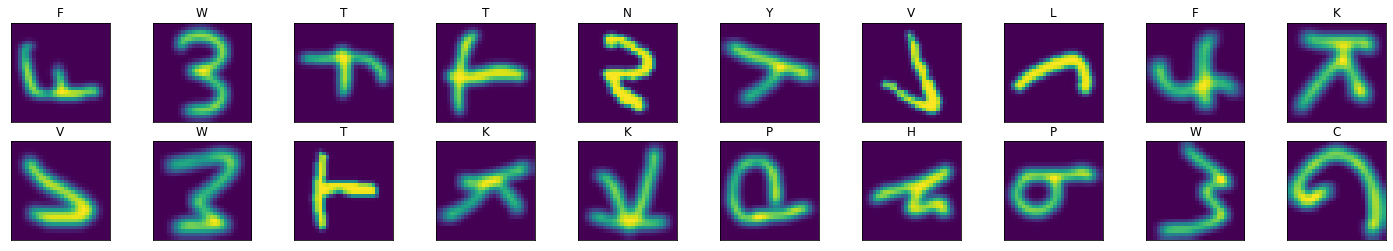

In [ ]:
classes = ['N/A','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

def img_convert(tensor):
  image = tensor
  if image.shape[2] == 1:
      image = image[:, :, 0]
  return image

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  plt.imshow(img_convert(np.transpose(images[idx], (1, 2, 0))))
  ax.set_title(classes[labels[idx]])

# The EMNIST CNN Model 

The code block below is the architecture of the CNN used for the EMNIST dataset. It consists of an _init_ method with the various layers of the CNN along with a _forward_ method that is what is used to build the architecture of the model. 

In [ ]:
class EMNISTClassifier(nn.Module): #same architecture as MNIST classifier 
      def __init__(self):
          super(EMNISTClassifier, self).__init__()
          self.conv1 = nn.Conv2d(1, 5, 5) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(160, 32)
          self.fc2 = nn.Linear(32, 27)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 160)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x
      

The method below is used to get the accuracy of the model on the final held out test set.

In [ ]:
def get_accuracy_test(model, train=False):
    if train:
        data = emnist_train
    else:
        data = emnist_test

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

The following codeblocks contain methods used to build and evaluate the various models implemented. Each method has been described below.



1. *get_accuracy*: used to get the accuracy on the train and validation datasets when training the model.
2. *train_SGD_SoftMax*: used to train a Softmax CNN model that uses the SGD optimizer. The training and validation accuracies are also plotted, along with the training loss. 
3. *train_SGD_SVM_L1*: used to train a L1-SVM CNN model that uses the Stochastic Gradient Descent (SGD) optimizer. The training and validation accuracies are also plotted, along with the training loss. 
4. *train_SGD_SVM_L2*: used to train a L2-SVM CNN model that uses the Stochastic Gradient Descent (SGD) optimizer. The training and validation accuracies are also plotted, along with the training loss. 
5. *train_Adam_SoftMax*: used to train a Softmax CNN model that uses the ADAM optimizer. The training and validation accuracies are also plotted, along with the training loss. 
6. *train_Adam_SVM_L1*: used to train a L1-SVM CNN model that uses the ADAM optimizer. The training and validation accuracies are also plotted, along with the training loss. 
7. *train_Adam_SVM_L2*: used to train a L2-SVM CNN model that uses the ADAM optimizer. The training and validation accuracies are also plotted, along with the training loss. 

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data = emnist_train #obtaining train or validation accuracy 
    else:
        data = emnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


def train_SGD_SoftMax(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #ptimizer = optim.Adam(model.parameters())

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)  
            #print("OUT", out.shape)           # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

The codeblock below is run to train the Softmax model using the SGD optimizer. The number of epochs may be changed to whichever value is suitable. 

CUDA is available!  Training on GPU ...


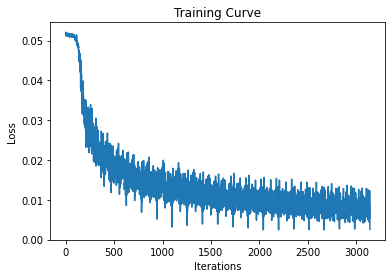

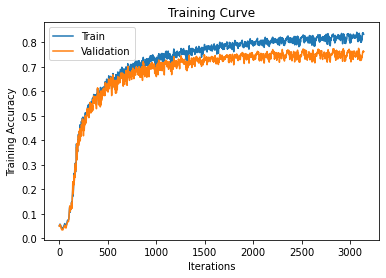

Final Training Accuracy: 0.8336
Final Validation Accuracy: 0.762


In [ ]:
#num epochs=20
use_cuda = True

model = EMNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_SGD_SoftMax(model, emnist_train, num_epochs=20)

The test accuracy on the held-out dataset is printed out below. 


In [ ]:
get_accuracy_test(model, train=False) # test acc for sgd softmax

0.724

In [ ]:
def train_SGD_SVM_L1(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss(p=1)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
   
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
      print("On Epoch #", epoch)
      for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)  
            #print("OUT", out.shape)           # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

 codeblock below is run to train the L1-SVM model using the SGD optimizer. The number of epochs may be changed to whichever value is suitable. 

CUDA is available!  Training on GPU ...
On Epoch # 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

On Epoch # 1
On Epoch # 2
On Epoch # 3
On Epoch # 4
On Epoch # 5
On Epoch # 6
On Epoch # 7
On Epoch # 8
On Epoch # 9
On Epoch # 10
On Epoch # 11
On Epoch # 12
On Epoch # 13
On Epoch # 14
On Epoch # 15
On Epoch # 16
On Epoch # 17
On Epoch # 18
On Epoch # 19


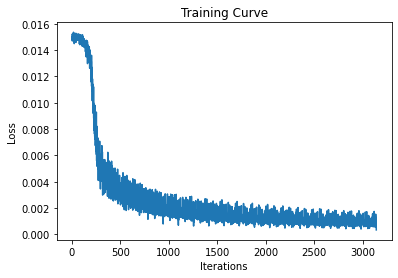

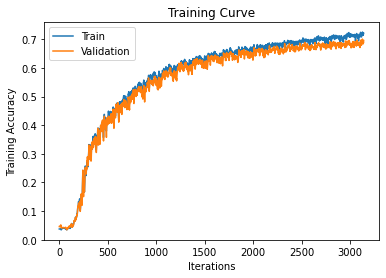

Final Training Accuracy: 0.7208
Final Validation Accuracy: 0.6955


In [ ]:
# run on 20 epochs, Multi Margin p =1
use_cuda = True

model = EMNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_SGD_SVM_L1(model, emnist_train, num_epochs=20)

The test accuracy on the held-out dataset is printed out below. 


In [ ]:
get_accuracy_test(model, train=False) # test acc for p = 1

0.689

In [ ]:
def train_SGD_SVM_L2(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss(p=2)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
   
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
      print("On Epoch #", epoch)
      for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)  
            #print("OUT", out.shape)           # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

The codeblock below is run to train the L2-SVM model using the SGD optimizer. The number of epochs may be changed to whichever value is suitable. 

CUDA is available!  Training on GPU ...
On Epoch # 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

On Epoch # 1
On Epoch # 2
On Epoch # 3
On Epoch # 4
On Epoch # 5
On Epoch # 6
On Epoch # 7
On Epoch # 8
On Epoch # 9
On Epoch # 10
On Epoch # 11
On Epoch # 12
On Epoch # 13
On Epoch # 14
On Epoch # 15
On Epoch # 16
On Epoch # 17
On Epoch # 18
On Epoch # 19


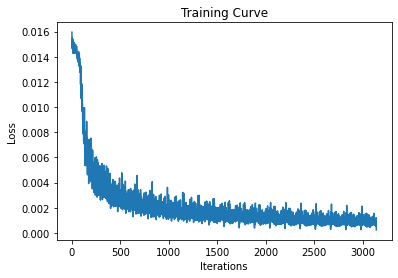

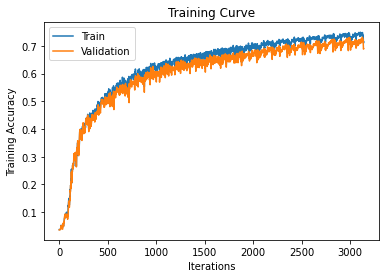

Final Training Accuracy: 0.7142
Final Validation Accuracy: 0.6895


In [ ]:
# run on 20 epochs, multi margin p = 2
use_cuda = True

model = EMNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_SGD_SVM_L2(model, emnist_train, num_epochs=20)

The test accuracy on the held-out dataset is printed out below. 


In [ ]:
get_accuracy_test(model, train=False) # test acc for p = 2

0.6775

In [ ]:
def train_Adam_SoftMax(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
   
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
      for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)  
            #print("OUT", out.shape)           # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

The codeblock below is run to train the Softmax model using the ADAM optimizer. The number of epochs may be changed to whichever value is suitable. 

CUDA is available!  Training on GPU ...


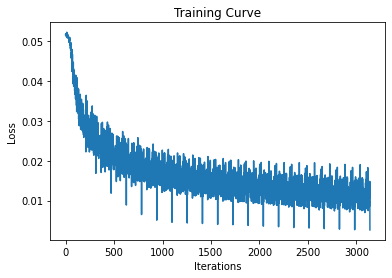

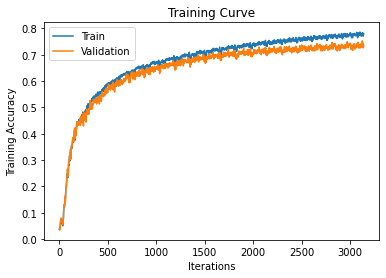

Final Training Accuracy: 0.7798
Final Validation Accuracy: 0.7355


In [ ]:
use_cuda = True

model = EMNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_Adam_SoftMax(model, emnist_train, num_epochs=20)

The test accuracy on the held-out dataset is printed out below. 


In [ ]:
get_accuracy_test(model, train=False) # test acc 

0.725

In [ ]:
def train_Adam_SVM_L1(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss(p=1)
    optimizer = optim.Adam(model.parameters())
   
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
      for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)  
            #print("OUT", out.shape)           # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

The codeblock below is run to train the L1-SVM model using the ADAM optimizer. The number of epochs may be changed to whichever value is suitable. 

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

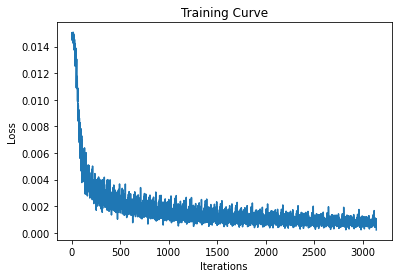

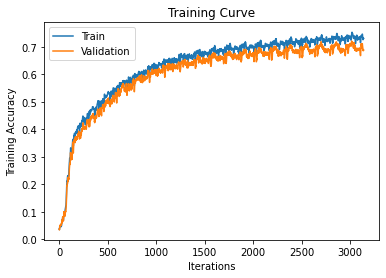

Final Training Accuracy: 0.7304
Final Validation Accuracy: 0.688


In [ ]:
#20 epochs w p=1
use_cuda = True

model = EMNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_Adam_SVM_L1(model, emnist_train, num_epochs=20)

The test accuracy on the held-out dataset is printed out below. 


In [ ]:
get_accuracy_test(model, train=False) # test acc p = 1

0.6845

In [ ]:
def train_Adam_SVM_L2(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss(p=2)
    optimizer = optim.Adam(model.parameters())
   
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
      for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)  
            #print("OUT", out.shape)           # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

The codeblock below is run to train the L2-SVM model using the ADAM optimizer. The number of epochs may be changed to whichever value is suitable. 

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

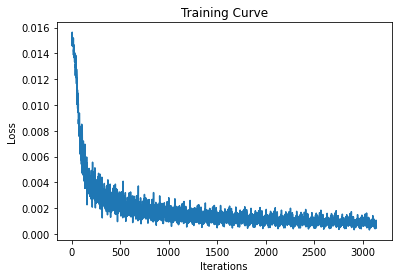

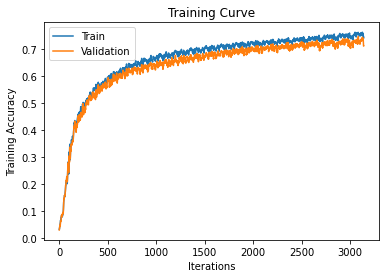

Final Training Accuracy: 0.7439
Final Validation Accuracy: 0.7115


In [ ]:
#20 epochs w p=2
use_cuda = True

model = EMNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_Adam_SVM_L2(model, emnist_train, num_epochs=20)

The test accuracy on the held-out dataset is printed out below. 


In [ ]:
get_accuracy_test(model, train=False) # test acc p = 2

0.7025